Clean notebook to plot Stokes parameters of NenuFAR dynamic spectra

In [1]:
import warnings
warnings.filterwarnings('ignore')

from nenupy.io import Spectra
from nenupy.io.tf import TFTask, TFPipeline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import QuadMesh
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido, attrs as a
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product

In [2]:
date     = '2025-03-25'
data_dir = '/databf/nenufar-tf/LT11'
obs_dir  = '20250325_091200_20250325_145000_SUN_TRACKING'

start_time            = '2025-03-25T09:35:00'
end_time              = '2025-03-25T09:42:00'
what_is_this_spectrum = 'typeIII_G1'

figsize = [7,4]

year, month, day = date.split('-')
spectra_files = sorted(glob.glob(f'{data_dir}/{year}/{month}/{obs_dir}/*.spectra'))

low_freq_path  = [ file for file in spectra_files if file.endswith('_0.spectra') ][0]
high_freq_path = [ file for file in spectra_files if file.endswith('_1.spectra') ][0]
print(low_freq_path, high_freq_path, sep='\n')

/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra
/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra


2025-05-06 14:28:10 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra...
2025-05-06 14:28:10 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra has been correctly parsed.
2025-05-06 14:28:10 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-06 14:28:11 | INFO: 	There are 3/22914 blocks containing missing data and/or wrong time information.
2025-05-06 14:28:11 | INFO: Computing time-frequency axes...
2025-05-06 14:28:11 | INFO: Re-organize data into Jones matrices...
2025-05-06 14:28:11 | INFO: 	Convert data to Dask array
2025-05-06 14:28:11 | INFO: Data loaded.
2025-05-06 14:28:11 | INFO: Selecting times (between 2025-03-25T09:35:00.000 and 2025-03-25T09:42:00.000)...
2025-05-06 14:28:11 | INFO: 	20029 time samples selected.
2025-05-06 14:28:11 | INFO: Selecting frequencies (between 21.6796875 MHz and 59.1796875 MH

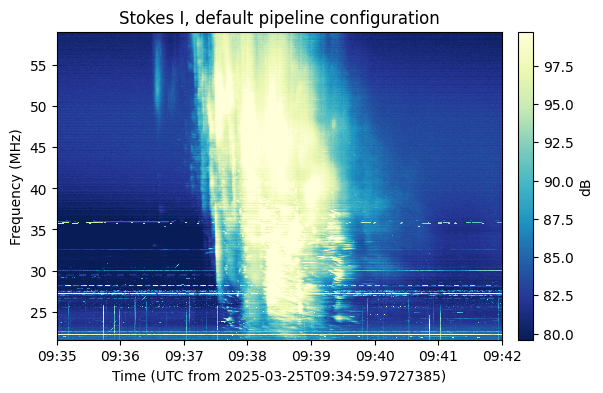

In [3]:
full_data = False
stokes_param = 'I'
low_data_i = Spectra(filename=low_freq_path)

if not full_data:
    low_data_i = low_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
    low_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')
else:
    low_data_i = low_data_i.get(stokes=stokes_param, ignore_volume_warning=True)
    low_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

2025-05-06 14:30:06 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra...
2025-05-06 14:30:06 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra has been correctly parsed.
2025-05-06 14:30:06 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-06 14:30:06 | INFO: 	There are 2/15276 blocks containing missing data and/or wrong time information.
2025-05-06 14:30:06 | INFO: Computing time-frequency axes...
2025-05-06 14:30:06 | INFO: Re-organize data into Jones matrices...
2025-05-06 14:30:06 | INFO: 	Convert data to Dask array
2025-05-06 14:30:06 | INFO: Data loaded.
2025-05-06 14:30:06 | INFO: Selecting times (between 2025-03-25T09:35:00.000 and 2025-03-25T09:42:00.000)...
2025-05-06 14:30:06 | INFO: 	20028 time samples selected.
2025-05-06 14:30:06 | INFO: Selecting frequencies (between 59.1796875 MHz and 84.1796875 MH

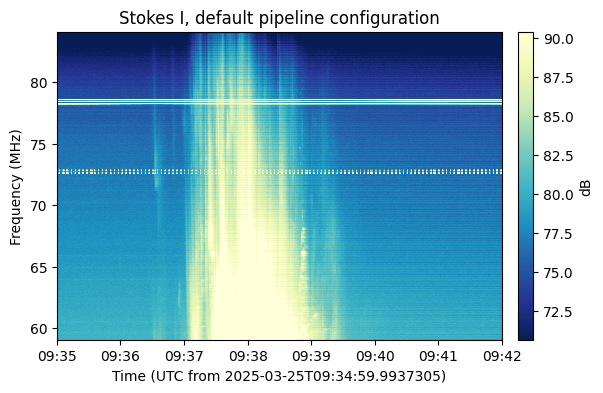

In [4]:
stokes_param = 'I'
high_data_i = Spectra(filename=high_freq_path)
high_data_i = high_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
high_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [13]:
low_times  = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])
high_times = np.array([datetime.utcfromtimestamp(t) for t in high_data_i.time.unix])

In [20]:
low_data_i.data.shape, high_data_i.data.shape

((20029, 6144, 1), (20028, 4096, 1))

In [23]:
str(high_times[0]), str(low_times[0])

('2025-03-25 09:34:59.993731', '2025-03-25 09:34:59.972739')

In [27]:
(high_times[0] - low_times[0]).total_seconds()*1e3

20.992

In [15]:
print(f'Difference in start times: {(high_times[0] - low_times[0]).total_seconds()*1e6} us')
print(f'Difference in end times: {(high_times[-1] - low_times[-1]).total_seconds()*1e6} us')
print(f'Low-freq time cadence: {np.diff(low_times)[0].total_seconds()*1e3:.2f} ms')
print(f'High-freq time cadence: {np.diff(high_times)[0].total_seconds()*1e3:.2f} ms')

Difference in start times: 20992.0 us
Difference in end times: 23.0 us
Low-freq time cadence: 20.97 ms
High-freq time cadence: 20.97 ms


In [16]:
low_dt_us  = [ t.total_seconds()*1e6 for t in np.diff(low_times) ]
high_dt_us = [ t.total_seconds()*1e6 for t in np.diff(high_times) ]

low_dt_ms  = [ t.total_seconds()*1e3 for t in np.diff(low_times) ]
high_dt_ms = [ t.total_seconds()*1e3 for t in np.diff(high_times) ]

In [17]:
combined_data  = np.concatenate((low_data_i.data, high_data_i.data), axis=1)
combined_data  = np.squeeze(combined_data)
combined_data  = 10 * np.log10(combined_data) # Convert the amplitude in decibels
combined_freqs = np.concatenate((low_data_i.freq.to_value('MHz'), high_data_i.freq.to_value('MHz')))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 20029 and the array at index 1 has size 20028

In [ ]:
# Save the combined data
combined_output_path = f'/home/mnedal/outputs/data/combined_spectra_{low_times[0].date()}_{what_is_this_spectrum}.npz'
np.savez(
    combined_output_path,
    data=combined_data,
    time=low_times,
    freq=combined_freqs
)
print(combined_output_path)

### Downsample NenuFAR dynamic spectrum to 1-second resolution
#### More practical for inspection

In [ ]:
# df_nenufar = pd.DataFrame(data=combined_data, index=low_times, columns=combined_freqs)
# df_nenufar.index.name = 'Time'
# df_nenufar.columns.name = 'Frequency'
# df_nenufar_1s = df_nenufar.resample('1S').mean()

In [ ]:
# fig = plt.figure(figsize=[10,7])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_nenufar_1s.index, df_nenufar_1s.columns, df_nenufar_1s.values.T,
#                    vmin=np.nanpercentile(df_nenufar_1s, 7), vmax=np.nanpercentile(df_nenufar_1s, 99.97),
#                    shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title('Downsampled to 1-s data')
# fig.tight_layout()
# plt.show()

## Show the full-resolution of NenuFAR radio spectrum

In [ ]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(low_times, combined_freqs, combined_data.T,
                   vmin=np.nanpercentile(combined_data, 7), vmax=np.nanpercentile(combined_data, 99.97),
                   shading='auto', cmap='Spectral_r') # Spectral_r, YlGnBu_r
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
fig.tight_layout()
plt.show()

In [ ]:
# # Comparison between the highres and downsampled data
# fig = plt.figure(figsize=[20,7])

# ax = fig.add_subplot(121)
# pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.values.T,
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title(f"Original time resolution {np.diff(df_nenufar.index)[0]/np.timedelta64(1, 'ms')} ms")

# ax = fig.add_subplot(122)
# pc = ax.pcolormesh(df_nenufar_1s.index, df_nenufar_1s.columns, df_nenufar_1s.values.T,
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title('Downsampled to 1-s data')

# fig.tight_layout()
# plt.show()

## Plot radio lightcurves

In [ ]:
radio_lightcurves = {}
f_targets = [30, 40, 50, 60, 70, 80] # freq channels conisdered

for f_target in f_targets:
    # Find index of closest value
    f_index      = np.abs(combined_freqs - f_target).argmin()
    freq_channel = f'{round(combined_freqs[f_index])} MHz'
    radio_lightcurves[freq_channel] = combined_data[:, f_index]

print(radio_lightcurves.keys())

In [ ]:
# Choose a colormap with many distinguishable colors
cmap        = plt.cm.get_cmap('Spectral')
num_lines   = len(radio_lightcurves.keys())
colors_list = cmap(np.linspace(0, 1, num_lines))

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lightcurves):
    ax.plot(low_times, radio_lightcurves[key], color=colors_list[i], label=key)

ax.legend(loc='best')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
# ax.legend(bbox_to_anchor=[1, 1])
ax.set_ylabel('Radio flux density (dB)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
ax.set_xlim(left=low_times[0], right=low_times[-1])
fig.tight_layout()
plt.show()

In [ ]:
# fig = plt.figure(figsize=[10, 7])
# ax = fig.add_subplot(111)

# # Plot the dynamic spectrum
# pc = ax.pcolormesh(low_times, combined_freqs, combined_data.T,
#                    vmin=60, vmax=125,
#                    shading='auto', cmap='Spectral_r')

# fig.colorbar(pc, ax=ax, label='dB')

# # Normalize the lightcurve to plot it visually on the frequency axis
# norm_curve = (radio_lightcurve - np.min(radio_lightcurve)) / (np.max(radio_lightcurve) - np.min(radio_lightcurve))
# freq_offset = 80  # e.g., 80 MHz
# freq_range = 5    # adjust vertical scaling

# ax.plot(low_times, freq_offset + norm_curve * freq_range, color='k', label='Lightcurve')

# # Labels and formatting
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.legend()
# plt.show()

In [ ]:
# fig, ax1 = plt.subplots(figsize=[10,7])

# # Plot dynamic spectrum on the left y-axis
# pc = ax1.pcolormesh(low_times, combined_freqs, combined_data.T,
#                     vmin=np.nanpercentile(combined_data, 7), vmax=np.nanpercentile(combined_data, 99.97),
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax1, label='dB')

# ax1.set_ylabel('Frequency (MHz)')
# ax1.xaxis_date()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax1.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')

# # Plot the radio lightcurve on a secondary y-axis (right)
# ax2 = ax1.twinx()
# # ax2.plot(low_times, radio_lightcurve, color='k', label='Lightcurve')
# for i, key in enumerate(radio_lightcurves):
#     ax2.plot(low_times, radio_lightcurves[key], color=colors_list[i], label=key)
# ax2.set_ylabel('Radio Intensity (arbitrary units)', color='k')
# ax2.tick_params(axis='y', labelcolor='k')
# # ax2.set_xlim(left=low_times[0], right=low_times[-1])

# fig.tight_layout()
# plt.show()

## Plot the STIX HXR lightcurves

In [ ]:
sci_query = Fido.search(a.Time(low_times[0], low_times[-1]),
                        a.Instrument.stix, a.stix.DataType.sci)
display(sci_query)

In [ ]:
sci_files = Fido.fetch(sci_query)
display(sci_files)

In [ ]:
spec = Product(sci_files)

if type(spec)==list:
    spec = spec[1]

In [ ]:
fig, ax = plt.subplots(figsize=[10,4])
spec.plot_spectrogram(axes=ax)
# Find the last QuadMesh artist added (likely your spectrogram)
im = [obj for obj in ax.get_children() if isinstance(obj, QuadMesh)][-1]
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(spec.meta['BUNIT'])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
# ax.set_xlim(left=low_times[0], right=low_times[-1])
fig.tight_layout()
plt.show()

In [ ]:
# Time(Sun to Earth) - Time(Sun to S/C)
time_delay = spec.meta['EAR_TDEL']
dt = timedelta(seconds=time_delay)
print(time_delay, dt)

In [ ]:
print(low_times[0] + dt, low_times[-1] + dt, sep='\n')

In [ ]:
# display(spec.energies)

In [ ]:
# # Sanity check ...
# e_channel = 4
# e_low     = spec.energies[spec.energies['channel']==e_channel]['e_low'][0].value
# e_high    = spec.energies[spec.energies['channel']==e_channel]['e_high'][0].value

In [ ]:
fig, ax = plt.subplots(figsize=[11,4])
spec.plot_timeseries(axes=ax, detector_indices=[[0,31]], pixel_indices=[[0,11]], energy_indices=[[1,6], [7,11], [12,16], [17,22], [23,27]])
ax.legend(bbox_to_anchor=(1, 0.55), title='Energies in keV')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Prevent x-tick label rotation
plt.setp(ax.get_xticklabels(), rotation=0)
# Center-align the labels
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_xlim(left=low_times[0]+dt, right=low_times[-1]+dt)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
ax.set_title(spec.meta['TELESCOP'])
fig.tight_layout()
plt.show()

In [ ]:
# Step 1: Convert ISO strings to datetime objects
times_str = spec.times.isot
times_dt = np.array([datetime.fromisoformat(t) for t in times_str])

# Step 2: Calculate time differences between consecutive timestamps
dt_tmp = np.diff(times_dt)

# Step 3: Convert to seconds
cadence_seconds = np.array([td.total_seconds() for td in dt_tmp])

print(f'Min cadence: {np.min(cadence_seconds)} s')
print(f'Max cadence: {np.max(cadence_seconds)} s')
print(f'Mean cadence: {np.mean(cadence_seconds):.3f} s')

In [ ]:
plt.figure(figsize=[10,3])
plt.plot(cadence_seconds)
plt.xlabel('No. of samples')
plt.ylabel('Time cadence (s)')
plt.title(spec.meta['TELESCOP'])
plt.show()

---

In [ ]:
# from stixpy.timeseries import quicklook # This registers the STIX timeseries with sunpy

# ql_lightcurves = TimeSeries(ql_files)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# ql_lightcurves.plot(axes=ax)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# # Prevent x-tick label rotation
# plt.setp(ax.get_xticklabels(), rotation=0)
# # Center-align the labels
# for label in ax.get_xticklabels():
#     label.set_horizontalalignment('center')
# # ax.set_xlim(left=low_times[0], right=low_times[-1])

# dt = timedelta(minutes=5)
# ax.set_xlim(left=low_times[0]-dt, right=low_times[-1])
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

In [ ]:
# print(ql_lightcurves.meta.metas[0]['keycomments']['EAR_TDEL'])
# for i, item in enumerate(ql_lightcurves.meta.metadata[0]):
#     if isinstance(item, dict) and 'EAR_TDEL' in item:
#         time_delay = item['EAR_TDEL']
#         print(time_delay)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# ql_lightcurves.plot(axes=ax)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# # Prevent x-tick label rotation
# plt.setp(ax.get_xticklabels(), rotation=0)
# # Center-align the labels
# for label in ax.get_xticklabels():
#     label.set_horizontalalignment('center')

# dt = timedelta(seconds=time_delay)
# ax.set_xlim(left=low_times[0]+dt, right=low_times[-1]+dt)
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

In [ ]:
# df_stix = ql_lightcurves.to_dataframe()
# df_stix.head(3)

In [ ]:
# df_stix = df_stix.filter(items=['4-10 keV','10-15 keV','15-25 keV','25-50 keV','50-84 keV'])
# df_stix.head(3)

In [ ]:
# for col in df_stix:
#     print(col)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# for col in df_stix:
#     ax.plot(df_stix.index, df_stix[col], label=col)
# ax.set_yscale('log')
# ax.legend()
# dt = timedelta(seconds=time_delay)
# ax.set_xlim(left=df_stix.index[0]+dt, right=df_stix.index[-1]+dt)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

---

Troupleshooting

In [ ]:
# stokes_param = 'Q'
# low_data_q = Spectra(filename=low_freq_path)
# low_data_q = low_data_q.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_q.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# stokes_param = 'U'
# low_data_u = Spectra(filename=low_freq_path)
# low_data_u = low_data_u.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_u.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# stokes_param = 'V'
# low_data_v = Spectra(filename=low_freq_path)
# low_data_v = low_data_v.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_v.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# u_i = low_data_u.data/low_data_i.data
# u_i = np.squeeze(u_i)
# freqs = low_data_i.freq.to_value('MHz')
# times = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])

# fig = plt.figure(figsize=[7,4])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(times, freqs, u_i.T,
#                     vmin=-0.5, vmax=0.5,
#                     shading='auto', cmap='seismic')
# fig.colorbar(pc, ax=ax, label='degree of U/I')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()